## Linear Regression with Time Series Data

In [2]:
import matplotlib.pyplot as plt 
import pandas as pd 
import plotly.express as px 
import pytz 
from pymongo import  MongoClient 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error 

### Prepare Data

In [ ]:
def wrangle(collection):
    results = collection.find(
        {"metadata.site": 29, "metadata.measurement": "P2"},
        projection={"P2": 1, "timestamp": 1, "_id": 0},
    )

    df = pd.DataFrame(results).set_index("timestamp")
    
    # Localize time zone
    df.index= df.index.tz_localize("UTC").tz_convert("Africa/Nairobi")
    # Remove Outlines
    df = df[df["P2"] < 500]
    
    # Resample
    df = df["P2"].resample("1H").mean().fillna(method="ffill").to_frame()
    
    # Add lag feature
    df["P2.L1"]=df["P2"].shift(1)
    
    # Drop NaN rows
    df.dropna(inplace=True)
    
    return df

In [13]:
# Import data
df = pd.read_csv("data/nairobi-city-air-quality.csv")
df.head()

,timestamp,P2
0,00:02.5,34.43
1,05:03.9,30.53
2,10:04.4,22.80
3,15:04.2,13.30
4,20:04.9,16.57


Localize time Zone by completing the wrangle function:

In [14]:
df = df.set_index("timestamp")
df.head()

,P2
timestamp,
00:02.5,34.43
05:03.9,30.53
10:04.4,22.80
15:04.2,13.30
20:04.9,16.57


In [ ]:
df.index = df.index.tz_localize("UTC").tz_convert("Africa/Nairobi")

Connect to Database

In [ ]:
client = MongoClient(host="localhost", port=27017)
db = client["air-quality"]
nairobi = db["nairobi"]

#### Explore

PM2.5 Boxplot

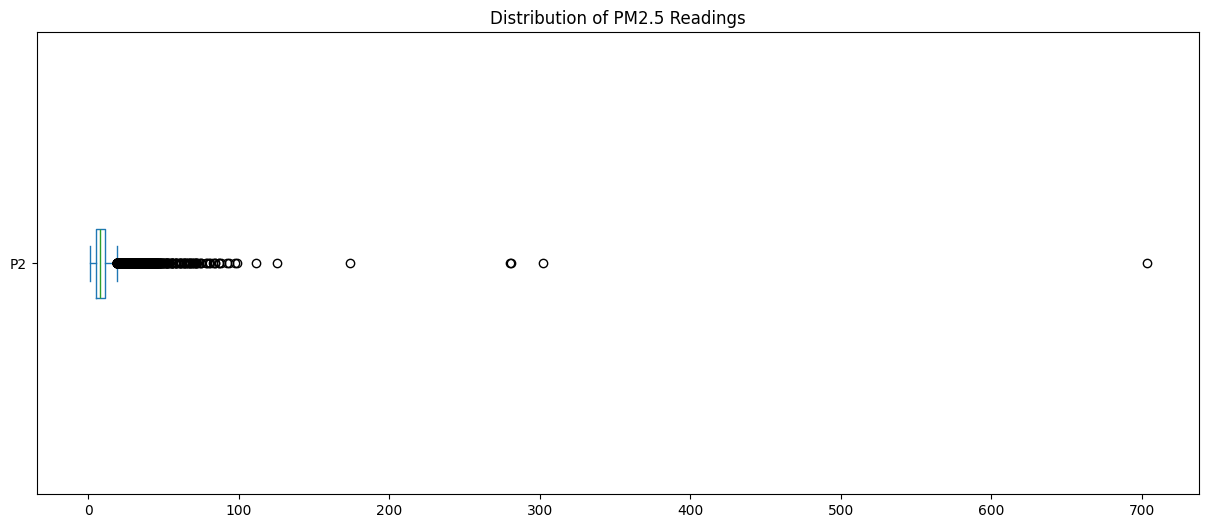

In [17]:
fig, ax = plt.subplots(figsize=(15, 6))
df["P2"].plot(kind="box", vert=False, title="Distribution of PM2.5 Readings", ax=ax);